In [1]:
%cd ..

/home/ubuntu/dev/edge/py-edge-eval


# Plot PR Curves

In [2]:
import os.path as osp

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [4]:
%matplotlib inline
# %matplotlib widget

In [5]:
thrsh_path= osp.join('data', 'BSDS500_bench', 'test_2', 'eval_bdry_thr.txt')
overall_path = osp.join('data', 'BSDS500_bench', 'test_2', 'eval_bdry.txt')

thrsh_path = osp.join('scripts', 'results', 'orig', 'eval_bdry_thr.txt')
overall_path = osp.join('scripts', 'results', 'orig', 'eval_bdry.txt')

assert osp.exists(thrsh_path)
assert osp.exists(overall_path)

In [6]:
thrsh_data = np.loadtxt(thrsh_path)
overall_data = np.loadtxt(overall_path)

In [7]:
thrsh_data 

array([[0.01    , 0.51216 , 0.484141, 0.497756],
       [0.02    , 0.559929, 0.516933, 0.537573],
       [0.03    , 0.579941, 0.53296 , 0.555459],
       [0.04    , 0.604072, 0.553486, 0.577674],
       [0.05    , 0.615389, 0.564103, 0.588631],
       [0.06    , 0.630645, 0.578527, 0.603463],
       [0.07    , 0.639813, 0.586925, 0.612229],
       [0.08    , 0.650056, 0.597279, 0.622551],
       [0.09    , 0.655758, 0.60373 , 0.62867 ],
       [0.1     , 0.665122, 0.614369, 0.638739],
       [0.11    , 0.671757, 0.622967, 0.646443],
       [0.12    , 0.675709, 0.628871, 0.651449],
       [0.13    , 0.68154 , 0.636369, 0.658181],
       [0.14    , 0.685989, 0.641618, 0.663062],
       [0.15    , 0.690585, 0.64875 , 0.669014],
       [0.16    , 0.693531, 0.654081, 0.673229],
       [0.17    , 0.698439, 0.661062, 0.679237],
       [0.18    , 0.701309, 0.665494, 0.682932],
       [0.19    , 0.704752, 0.671719, 0.687839],
       [0.2     , 0.706571, 0.675078, 0.690466],
       [0.21    , 0.

In [8]:
thrsh_data[:, 1] >= 1e-3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [9]:
overall_data

array([0.55    , 0.697447, 0.823979, 0.755451, 0.716879, 0.840207,
       0.773659, 0.65523 ])

ODS=0.755, OIS=0.774, AP=0.655, R50=0.535


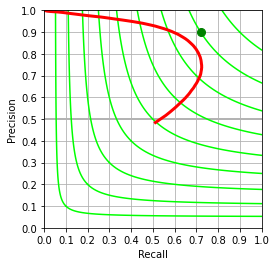

In [10]:
cols = list("rgbkmr" * 100)
cols = np.array(cols)

plt.figure()
ax = plt.gca()
plt.box(True)
plt.grid(True)
plt.axhline(0.5, 0, 1, linewidth=2, color=[0.7, 0.7, 0.7])
for f in np.arange(0.1, 1, 0.1):
    r = np.arange(f, 1.01, 0.01)
    p = f * r / (2 * r - f)
    plt.plot(r, p, color=[0, 1, 0])
    plt.plot(p, r, color=[0, 1, 0])
    
# human performance on the bsds500
h = plt.plot(
    0.7235,
    0.9014,
    marker="o",
    markersize=8,
    color=[0, 0.5, 0],
    markerfacecolor=[0, 0.5, 0],
    markeredgecolor=[0, 0.5, 0],
)

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("Recall")
plt.ylabel("Precision")
ax.set_aspect("equal", adjustable="box")
plt.axis([0, 1, 0, 1])

# load results for every algorithm (pr=[T, R, P, F])
pr = thrsh_data[thrsh_data[:, 1] >= 1e-3]
_, o = np.unique(pr[:, 2], return_index=True)
r50 = interp1d(
    pr[o, 2],
    pr[o, 1],
    bounds_error=False,
    fill_value=np.nan,
)(np.maximum(pr[o[0], 2], 0.5))
res = np.zeros((9), np.float32)
res[:8] = overall_data
res[8] = r50

# plot results for every algorithm (plot best last)
hs = plt.plot(
    pr[:, 1],
    pr[:, 2],
    linestyle="-",
    linewidth=3,
    color=cols[0],
)
prefix = "ODS={:.3f}, OIS={:.3f}, AP={:.3f}, R50={:.3f}".format(
    *res[[3, 6, 7, 8]]
)
print(prefix)

# hs = h + hs

plt.show()